### Vision Transformer Pytorch Implementation

#### AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE

Alexey Dosovitskiy, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, Jakob Uszkoreit, Neil Houlsby

https://arxiv.org/abs/2010.11929

![Vision Transformer Architecture](vit.png "vit")

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torchvision
import matplotlib.pyplot as plt
print('done')

done


### MNIST Dataset

In [6]:
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST('mnist_dataset/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256)

test_dataset = torchvision.datasets.MNIST('mnist_dataset/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256)
print('done')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_dataset/MNIST/raw/train-images-idx3-ubyte.gz to mnist_dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_dataset/MNIST/raw

done


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


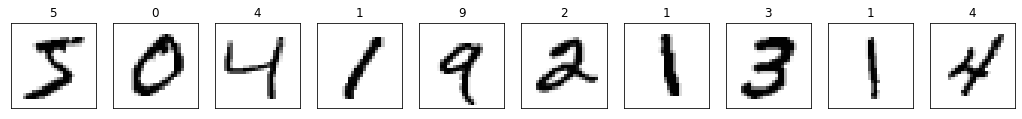

In [7]:
plt.figure(figsize=[18, 3])
for i in range(10):
    images, targets = train_dataset[i]
    plt.subplot(1, 10, i+1)
    plt.title(str(targets))
    plt.imshow(images[0], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
plt.show()

### Model Definition

In [8]:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
    
class VisionTransformer(nn.Module):
    def __init__(self, in_channels=1, n_classes=10, patch_size=7, d_model=256, n_heads=4, num_layers=6):
        super().__init__()
        self.patch_embedding = nn.Conv2d(in_channels=in_channels, out_channels=d_model,
                                         kernel_size=patch_size, stride=patch_size)
        self.positional_encoding = PositionalEncoding(d_model)
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model))
        transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.mlp_head = nn.Sequential(nn.Linear(d_model, d_model),
                                      nn.Tanh(),
                                      nn.Linear(d_model, n_classes))
              
    def forward(self, x):
        # x : (batch, channel, height, width)=(batch, 1, 28, 28)
        
        '''patch embedding'''
        # (batch, d_model, height, width)=(batch, 256, 4, 4)
        x = self.patch_embedding(x)
        batch, d_model, height, width = x.size()
        # (batch, d_model, height*width)=(batch, 256, 16)
        x = x.reshape(batch, d_model, height*width)
        # (batch, height*width, d_model)
        x = x.permute(0, 2, 1)
        
        '''concat class token '''
        # (batch, 1, d_model)
        class_token = torch.tile(self.class_token, (batch, 1, 1))
        # (batch, 1+height*width, d_model)
        x = torch.cat([class_token, x], dim=1)
        x = self.positional_encoding(x)
        
        '''Transformer'''
        # (batch, 1+height*width, d_model)
        x = self.transformer(x)
        
        '''MLP head'''
        # (batch, d_model)
        #x = x[:, 0]
        x = x.mean(dim=1)
        # (batch, n_classes)
        y = self.mlp_head(x)
        
        return y

### Model Initialization

In [9]:
model = VisionTransformer()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
print('done')

done


### Training

In [10]:
from tqdm.notebook import tqdm
def train_steps(train_loader, model, optimizer):
    print('Training...')
    model.train()
    averaged_loss = None
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, targets) in pbar:
        ''' to GPU'''
        # (batch, channel=1, height=28, width=28)
        images = images.cuda()
        # (batch,)
        targets = targets.cuda()

        ''' forward pass'''
        model.zero_grad()
        # (batch, n_classes=10)
        preds = model(images)
        
        '''backward pass'''
        loss = nn.CrossEntropyLoss()(preds, targets)
        loss.backward()
        
        '''weight update'''
        optimizer.step()
        averaged_loss = loss if averaged_loss is None else averaged_loss*0.9 + loss.item()*0.1
        pbar.set_description('loss : %2.3f'%averaged_loss)

In [11]:
def test_steps(test_loader, model):
    print('Test...')
    model.eval()
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))
    corrects = []
    for i, (images, targets) in pbar:
        ''' to GPU'''
        # (batch, channel=1, height=28, width=28)
        images = images.cuda()
        # (batch,)
        targets = targets.cuda()

        ''' forward pass'''
        with torch.no_grad():
            # (batch, n_classes=10)
            preds = model(images)
            # (batch,)
            preds = preds.argmax(dim=1)
        
        # (batch,)
        correct = (preds == targets)
        corrects.append(correct)
    # (batch,)
    corrects = torch.cat(corrects, dim=0)
    accuracy = corrects.sum() / len(corrects)
    
    print('accuracy : %2.3f'%(accuracy*100))
    

In [12]:
Epochs = 5
for epoch in range(Epochs):
    print('Epoch :', epoch+1)
    train_steps(train_loader, model, optimizer)
    test_steps(test_loader, model)

Epoch : 1
Training...


  0%|          | 0/235 [00:00<?, ?it/s]

Test...


  0%|          | 0/40 [00:00<?, ?it/s]

accuracy : 78.070
Epoch : 2
Training...


  0%|          | 0/235 [00:00<?, ?it/s]

Test...


  0%|          | 0/40 [00:00<?, ?it/s]

accuracy : 93.680
Epoch : 3
Training...


  0%|          | 0/235 [00:00<?, ?it/s]

Test...


  0%|          | 0/40 [00:00<?, ?it/s]

accuracy : 95.410
Epoch : 4
Training...


  0%|          | 0/235 [00:00<?, ?it/s]

Test...


  0%|          | 0/40 [00:00<?, ?it/s]

accuracy : 96.150
Epoch : 5
Training...


  0%|          | 0/235 [00:00<?, ?it/s]

Test...


  0%|          | 0/40 [00:00<?, ?it/s]

accuracy : 96.500


### Test

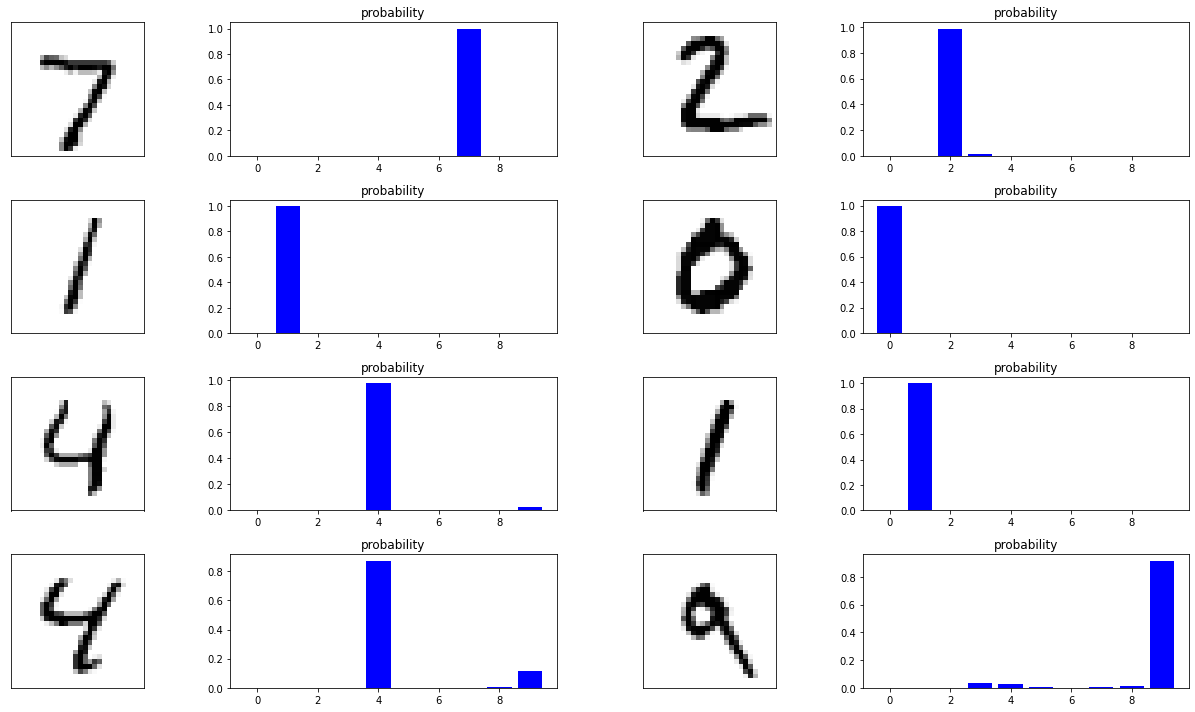

In [13]:

model.eval()
corrects = []
for i, (images, targets) in enumerate(test_loader):
    ''' to GPU'''
    # (batch, channel=1, height=28, width=28)
    images = images.cuda()
    # (batch,)
    targets = targets.cuda()

    ''' forward pass'''
    with torch.no_grad():
        # (batch, n_classes=10)
        preds = model(images)
        preds = preds.softmax(dim=1)
    
    _images = images.data.cpu().numpy()
    _preds = preds.data.cpu().numpy()
    plt.figure(figsize=[18, 10])
    for i in range(8):
        plt.subplot(4, 4, i*2+1)
        plt.imshow(_images[i, 0], cmap=plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 4, i*2+2)
        plt.title('probability')
        plt.bar(list(range(10)), _preds[i], color='blue')

    plt.tight_layout()
    plt.show()
    break